In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-05-05 21:46:56.936598: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 21:46:56.942343: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 21:46:57.014574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 21:47:00.513344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


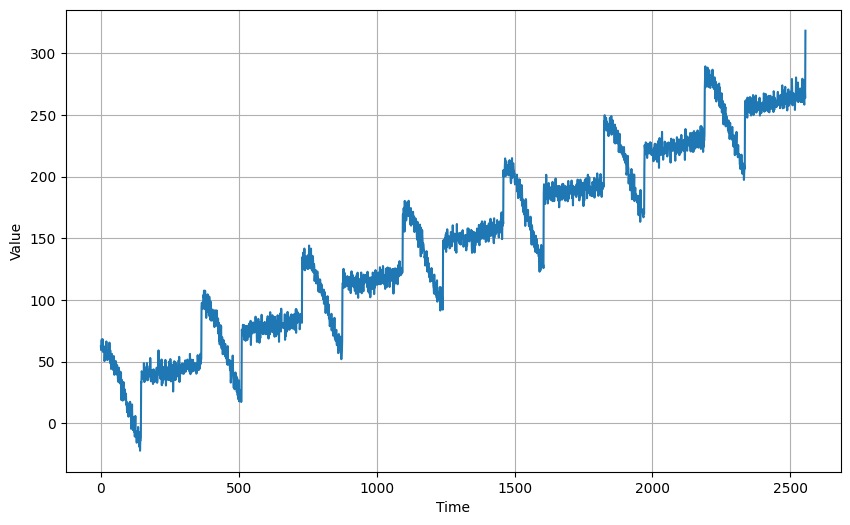

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

def normalize_data(train_data, valid_data, lower_percent, upper_percent):
    """
    Normalize training and validation data to a custom range where a certain percentage is mapped to values less than zero.
    
    Parameters:
    train_data (array-like): The training data to be normalized.
    valid_data (array-like): The validation data to be normalized.
    lower_percent (float): The percentage of the range to map to values less than zero.
    upper_percent (float): The percentage of the range to map to values greater than zero.
    
    Returns:
    tuple: A tuple containing the normalized training and validation data.
    """
    min_val = min(train_data)
    max_val = max(train_data)
    range_of_values = np.ptp(train_data) 
    min_val = min_val - range_of_values*0.3
    max_val = max_val + range_of_values*0.3
    normalized_train_data = [(x - min_val) / (max_val - min_val) for x in train_data]
    normalized_valid_data = [(x - min_val) / (max_val - min_val) for x in valid_data]
    return normalized_train_data, normalized_valid_data

time = np.arange(7 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 50
slope = 0.1
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

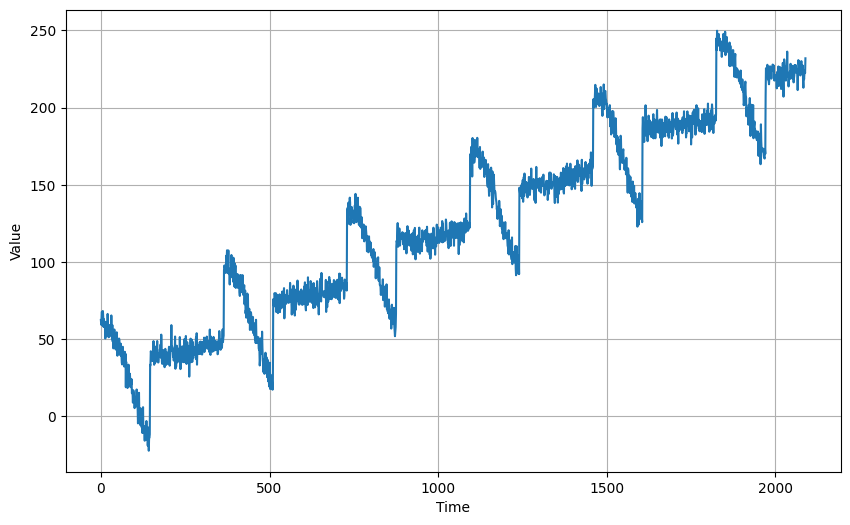

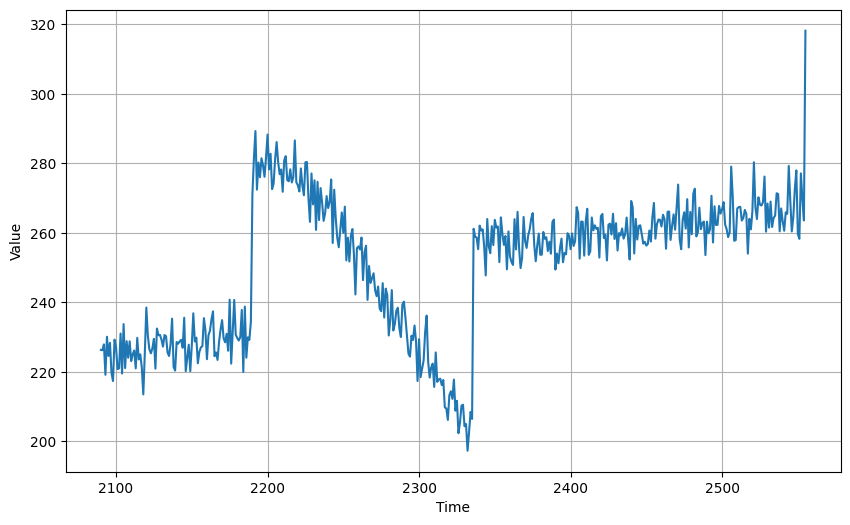

In [3]:
split_time = 365*6-100

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

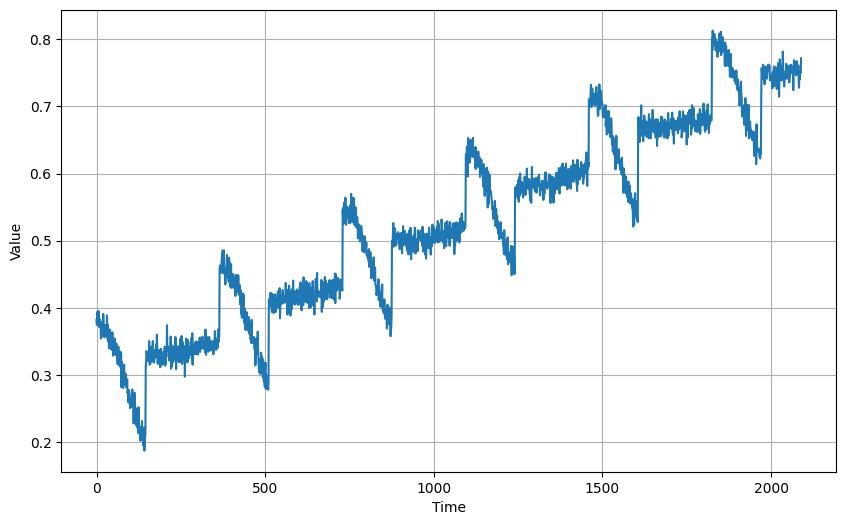

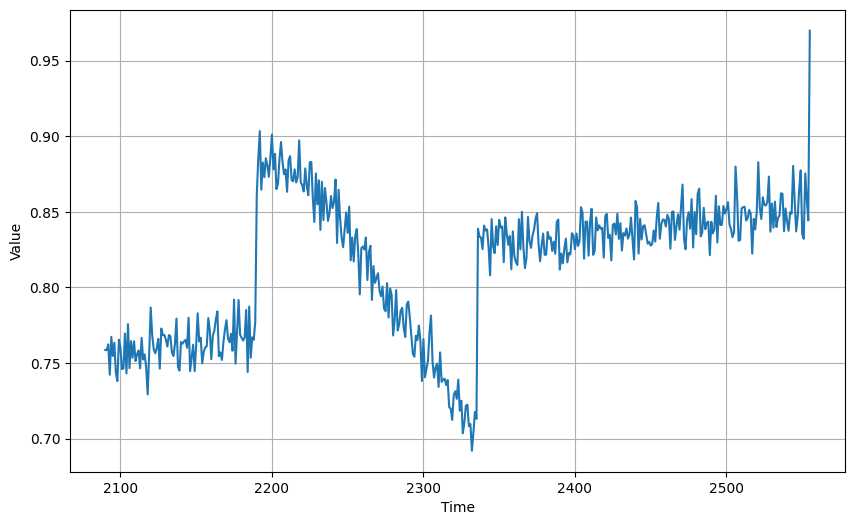

In [4]:
lower_percent = 0.5
upper_percent = 0.5

x_train_reshaped = x_train.reshape(-1, 1)
x_valid_reshaped = x_valid.reshape(-1, 1)

x_train_reshaped, x_valid_reshaped = normalize_data(x_train_reshaped, x_valid_reshaped, lower_percent , upper_percent)

plot_series(time_train, x_train_reshaped)
plot_series(time_valid, x_valid_reshaped)

In [5]:
window_size = 30

x_train_window =[]
y_train_window =[]
x_valid_window =[]
y_valid_window =[]

x_train_reshaped = np.array(x_train_reshaped)
x_valid_reshaped = np.array(x_valid_reshaped)

for i in range (window_size, split_time):
    x_train_window.append(x_train_reshaped[i-window_size:i, 0])
    y_train_window.append(x_train_reshaped[i, 0])



for i in range (window_size,time_valid.shape[0] ):
  x_valid_window.append(x_valid_reshaped[i-window_size:i,0])
  y_valid_window.append(x_valid_reshaped[i,0])

X_train, y_train, X_valid, y_valid = np.array(x_train_window), np.array(y_train_window), np.array(x_valid_window), np.array(y_valid_window)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.callbacks import ModelCheckpoint
import itertools
import os
import pandas as pd
from tqdm import tqdm

# Define the hyperparameters you want to iterate over
activations = ['relu', 'tanh']
num_of_layers = [0, 1, 2, 3]
units = 50
dropout_rate = 0.2
epochs = 1000

# Loop over the combinations
for activation, num_layers in itertools.product(activations, num_of_layers):
    history_file_path = f'training_history_{num_layers}_{units}_{activation}.csv'
    if os.path.exists(history_file_path):
        print(f"Training history already exists for Activation={activation}, Num Layers={num_layers}. Skipping...")
        continue

    print(f"Training Neural Network: Activation={activation}, Num Layers={num_layers}")
    # Initialising the GRU model
    regressor = Sequential()

    # Adding the first GRU layer and some Dropout regularisation
    regressor.add(GRU(units=units, input_shape=(X_train.shape[1], 1), activation=activation, return_sequences=True))
    regressor.add(Dropout(dropout_rate))

    # Adding more GRU layers
    for _ in range(num_layers - 1):
        regressor.add(GRU(units=units, activation=activation, return_sequences=True))
        regressor.add(Dropout(dropout_rate))

    regressor.add(GRU(units=units, activation=activation))
    regressor.add(Dropout(dropout_rate))
    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compile the model with Adam optimizer and specific learning rate
    optimizer = Adam()
    regressor.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    # Define a ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint(f'best_model_GRU_{num_layers}_{units}_{activation}.keras', monitor='val_mean_absolute_error', mode='min', save_best_only=True)

    # Fitting the GRU model to the Training set with the ModelCheckpoint callback
    progress_bar = tqdm(total=epochs, desc=f"Progress: Activation={activation}, Num Layers={num_layers}", position=0, leave=True)
    for epoch in range(epochs):
        history = regressor.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_valid, y_valid), verbose=0, callbacks=[checkpoint])
        progress_bar.update(1)  # Update the progress bar
        progress_bar.set_postfix(loss=history.history['loss'][0], val_loss=history.history['val_loss'][0])
    progress_bar.close()

    history_df = pd.DataFrame({
        'epoch': range(1, len(history.history['loss']) + 1),
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'mean_absolute_error': history.history['mean_absolute_error'],
        'val_mean_absolute_error': history.history['val_mean_absolute_error']
    })
    history_df.to_csv(f'training_history_{num_layers}_{units}_{activation}.csv', index=False)


Training history already exists for Activation=relu, Num Layers=0. Skipping...
Training history already exists for Activation=relu, Num Layers=1. Skipping...
Training history already exists for Activation=relu, Num Layers=2. Skipping...
Training history already exists for Activation=relu, Num Layers=3. Skipping...
Training history already exists for Activation=tanh, Num Layers=0. Skipping...
Training history already exists for Activation=tanh, Num Layers=1. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=3. Skipping...


2024-05-05 21:47:07.796829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 21:47:07.798079: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6244e-04 - mean_absolute_error: 0.0125
Model Number of Layers: 0, activation : relu
Validation Loss: 0.00035617739195004106
Validation Mean Absolute Error: 0.012370720505714417
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


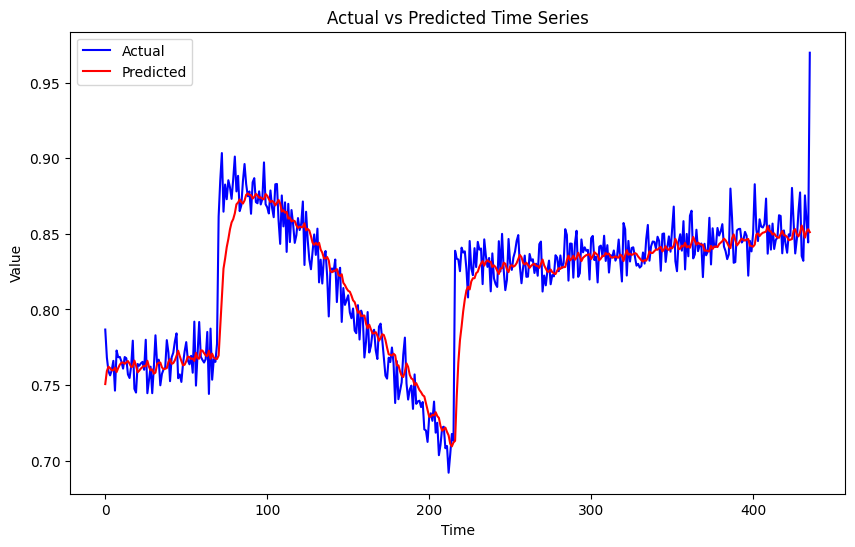

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4635e-04 - mean_absolute_error: 0.0125
Model Number of Layers: 1, activation : relu
Validation Loss: 0.00034444700577296317
Validation Mean Absolute Error: 0.012509414926171303
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


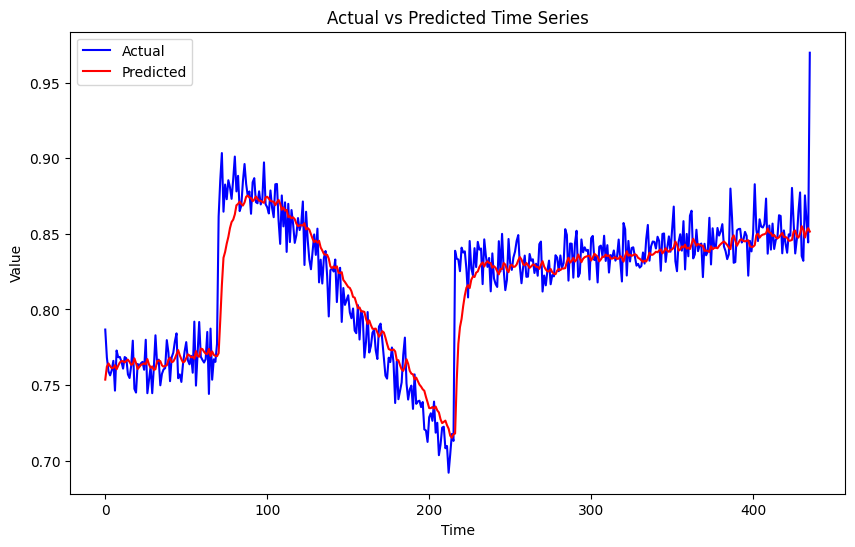

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4565e-04 - mean_absolute_error: 0.0136
Model Number of Layers: 2, activation : relu
Validation Loss: 0.00043671575258485973
Validation Mean Absolute Error: 0.013583725318312645
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


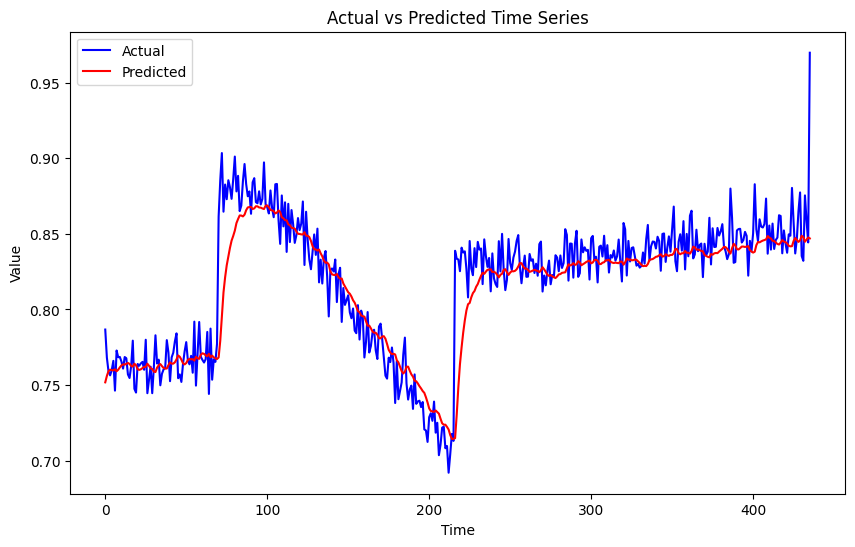

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5695e-04 - mean_absolute_error: 0.0154
Model Number of Layers: 3, activation : relu
Validation Loss: 0.0006248940480872989
Validation Mean Absolute Error: 0.015361771918833256
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


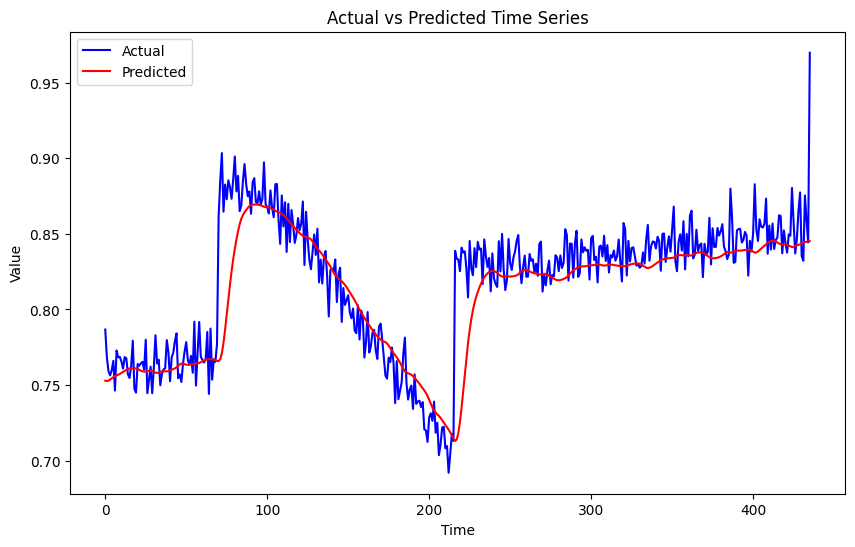

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3867e-04 - mean_absolute_error: 0.0108
Model Number of Layers: 0, activation : tanh
Validation Loss: 0.0002557460102252662
Validation Mean Absolute Error: 0.010859234258532524
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


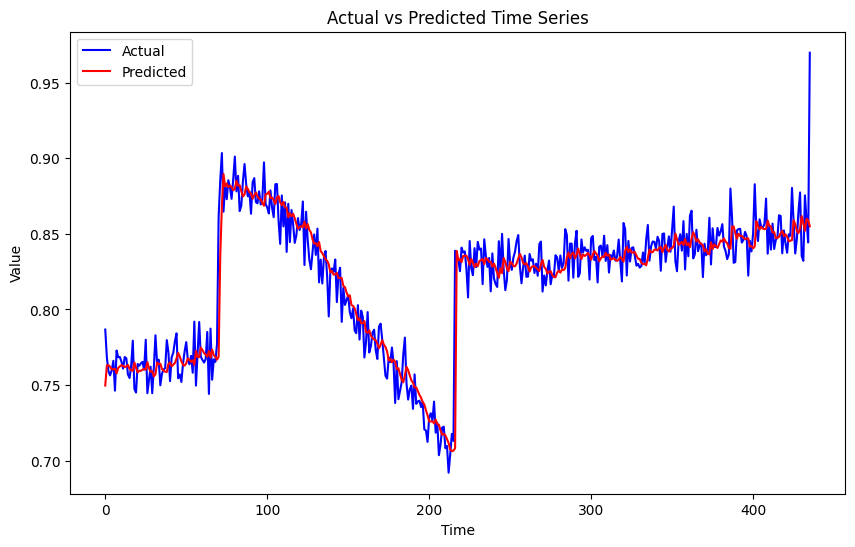

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3621e-04 - mean_absolute_error: 0.0107
Model Number of Layers: 1, activation : tanh
Validation Loss: 0.00025408106739632785
Validation Mean Absolute Error: 0.010810235515236855
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


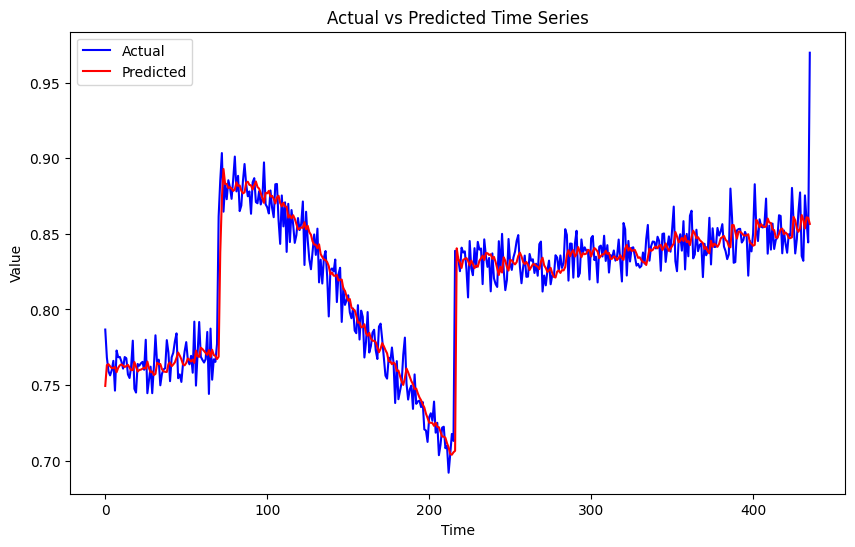

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3607e-04 - mean_absolute_error: 0.0107
Model Number of Layers: 2, activation : tanh
Validation Loss: 0.00025384765467606485
Validation Mean Absolute Error: 0.010799681767821312
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


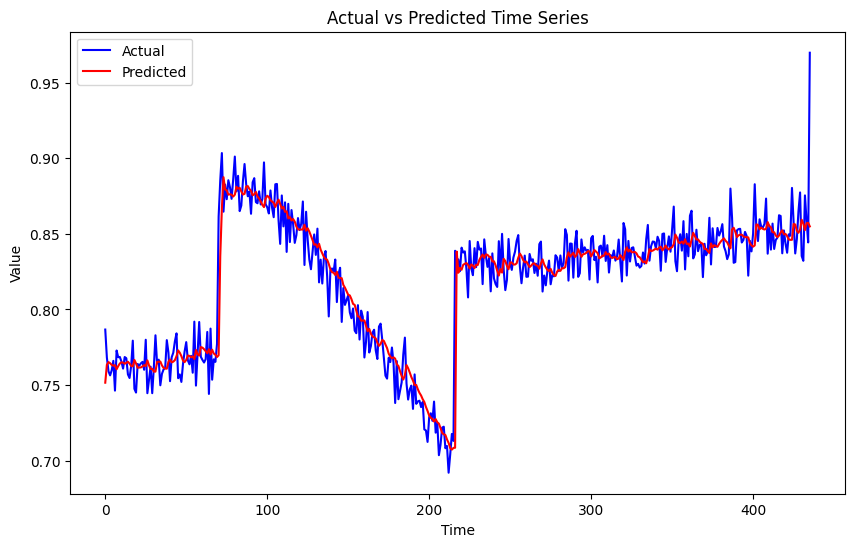

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3774e-04 - mean_absolute_error: 0.0107
Model Number of Layers: 3, activation : tanh
Validation Loss: 0.0002563565212767571
Validation Mean Absolute Error: 0.010844559408724308
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


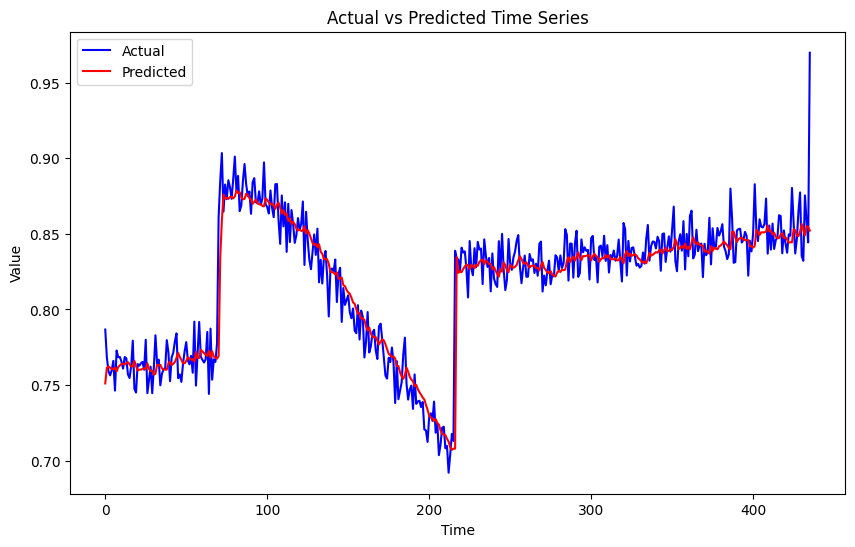

Best model found:
Number of Layers: 2
Units: 50
Activation: tanh
Validation Loss: 0.00025384765467606485


In [7]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.callbacks import ModelCheckpoint
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

from keras.models import load_model

import itertools

activations = ['relu', 'tanh']
num_of_layers = [0, 1, 2, 3]
units = 50

smallest_error = float('inf')  # Initialize smallest error to positive infinity
best_model_info = None

# Loop over the combinations
for activation, num_layers in itertools.product(activations, num_of_layers):
    model_name = f'best_model_GRU_{num_layers}_{units}_{activation}.keras'
    loaded_model = load_model(model_name) 
    loss, mae = loaded_model.evaluate(X_valid, y_valid)
    print(f"Model Number of Layers: {num_layers}, activation : {activation}")
    print("Validation Loss:", loss)
    print("Validation Mean Absolute Error:", mae)
    
    # Check if current model has smallest error
    if loss < smallest_error:
        smallest_error = loss
        best_model_info = (num_layers, units, activation)
    
    y_pred = loaded_model.predict(X_valid)
    # Assuming timestamps are available for both y_pred and y_valid
    timestamps = range(len(y_valid))
    # Plot y_pred vs y_valid
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_valid, label='Actual', color='blue')
    plt.plot(timestamps, y_pred, label='Predicted', color='red')
    plt.title('Actual vs Predicted Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

print("Best model found:")
print("Number of Layers:", best_model_info[0])
print("Units:", best_model_info[1])
print("Activation:", best_model_info[2])
print("Validation Loss:", smallest_error)


In [8]:
import os
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError

activations = [best_model_info[2]]
num_layers_list = [best_model_info[0]]
units = [25, 50, 100, 150, 200, 250]
dropout_rate = 0.2
epochs = 1000

# Loop over configurations
for activation in activations:
    for num_layers in num_layers_list:
        for unit in units:
            history_file_path = f'training_history_{num_layers}_{unit}_{activation}.csv'
            if os.path.exists(history_file_path):
                print(f"Training history already exists for Activation={activation}, Num Layers={num_layers}. Skipping...")
                continue
                
            print(f"Training Neural Network: Activation={activation}, Num Layers={num_layers}, Units={unit}")
            regressor = Sequential()

            regressor.add(GRU(units=unit, input_shape=(X_train.shape[1], 1), activation=activation, return_sequences=True))
            regressor.add(Dropout(dropout_rate))

            for _ in range(num_layers - 1):
                regressor.add(GRU(units=unit, activation=activation, return_sequences=True))
                regressor.add(Dropout(dropout_rate))

            regressor.add(GRU(units=unit, activation=activation))
            regressor.add(Dropout(dropout_rate))

            regressor.add(Dense(units=1))

            optimizer = Adam()
            regressor.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])

            checkpoint = ModelCheckpoint(f'best_model_GRU_{num_layers}_{unit}_{activation}.keras', monitor='val_mean_absolute_error', mode='min', save_best_only=True)

            progress_bar = tqdm(total=epochs, desc=f"Progress: Activation={activation}, Num Layers={num_layers}, Units={unit}", position=0, leave=True)
            for epoch in range(epochs):
                history = regressor.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_valid, y_valid), verbose=0, callbacks=[checkpoint])
                progress_bar.set_postfix(loss=history.history['loss'][0], val_loss=history.history['val_loss'][0])
                progress_bar.update(1)  # Update the progress bar
            progress_bar.close()

            history_df = pd.DataFrame({
                'epoch': range(1, len(history.history['loss']) + 1),
                'loss': history.history['loss'],
                'val_loss': history.history['val_loss'],
                'mean_absolute_error': history.history['mean_absolute_error'],
                'val_mean_absolute_error': history.history['val_mean_absolute_error']
            })
            history_df.to_csv(f'training_history_{num_layers}_{unit}_{activation}.csv', index=False)


Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...
Training history already exists for Activation=tanh, Num Layers=2. Skipping...


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Model Number of Layers: 2, Units: 25, Activation: tanh
Validation Mean Absolute Error: 0.011044432
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Model Number of Layers: 2, Units: 50, Activation: tanh
Validation Mean Absolute Error: 0.010799682
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Model Number of Layers: 2, Units: 100, Activation: tanh
Validation Mean Absolute Error: 0.010815963
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
Model Number of Layers: 2, Units: 150, Activation: tanh
Validation Mean Absolute Error: 0.010798126
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Model Number of Layers: 2, Units: 200, Activation: tanh
Validation Mean Absolute Error: 0.010807579
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
Model Number of Layers: 2, Units: 250, Activation: tanh
Validation Mean Absolute Error: 0.010827108
Best model found:
Number of Layers: 2
Units: 150
Activation: tanh
Smallest Validation Mean Absolute Error: 0.010798126


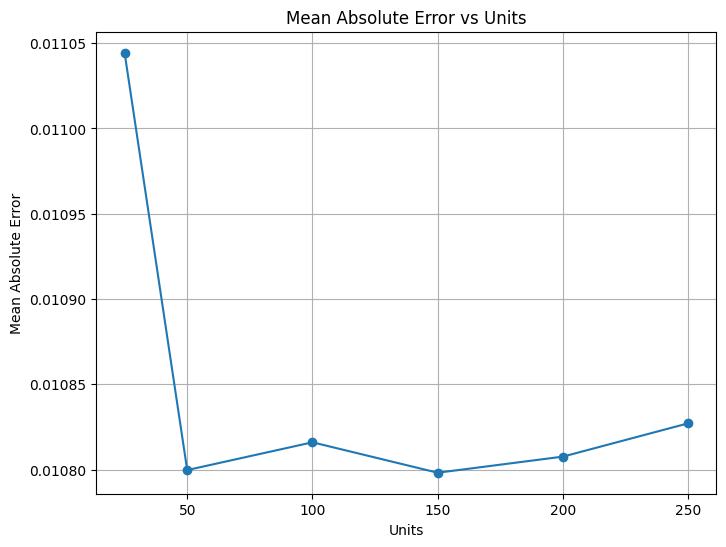

In [9]:
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanAbsoluteError


num_of_layers = [best_model_info[0]]
units = [25, 50, 100, 150, 200, 250]

smallest_error = float('inf')  # Initialize smallest error to positive infinity
best_model_info = None
mae_values = []  # Store MAE values for plotting
unit_values = []  # Store unit values for plotting

# Loop over the combinations
for activation, num_layers in itertools.product(activations, num_of_layers):
    for unit in units:
        model_name = f'best_model_GRU_{num_layers}_{unit}_{activation}.keras'
        loaded_model = load_model(model_name) 
        y_pred = loaded_model.predict(X_valid)
        mae_metric = MeanAbsoluteError()
        mae_metric.update_state(y_valid, y_pred)
        mae = mae_metric.result().numpy()  # Extract MAE value
        mae_values.append(mae)
        unit_values.append(unit)
        print(f"Model Number of Layers: {num_layers}, Units: {unit}, Activation: {activation}")
        print("Validation Mean Absolute Error:", mae)
        if mae < smallest_error:
            smallest_error = mae
            best_model_info = (num_layers, unit, activation)

print("Best model found:")
print("Number of Layers:", best_model_info[0])
print("Units:", best_model_info[1])
print("Activation:", best_model_info[2])
print("Smallest Validation Mean Absolute Error:", smallest_error) 

# Plot MAE vs Units
plt.figure(figsize=(8, 6))
plt.plot(unit_values, mae_values, marker='o', linestyle='-')
plt.title('Mean Absolute Error vs Units')
plt.xlabel('Units')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()

In [10]:
with open('model_info.txt', 'w') as f:
    # Write the information to the file
    f.write("Best model found GRU:\n")
    f.write("Number of Layers: {}\n".format(best_model_info[0]))
    f.write("Units: {}\n".format(best_model_info[1]))
    f.write("Activation: {}\n".format(best_model_info[2]))
    f.write("Smallest Validation Mean Absolute Error: {}\n".format(smallest_error))

# Print confirmation message
print("Model information saved to model_info.txt")


Model information saved to model_info.txt


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.3186e-04 - mean_absolute_error: 0.0106
Model Number of Layers: 2, activation : tanh
Validation Loss: 0.00025208035367541015
Validation Mean Absolute Error: 0.010798126459121704
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


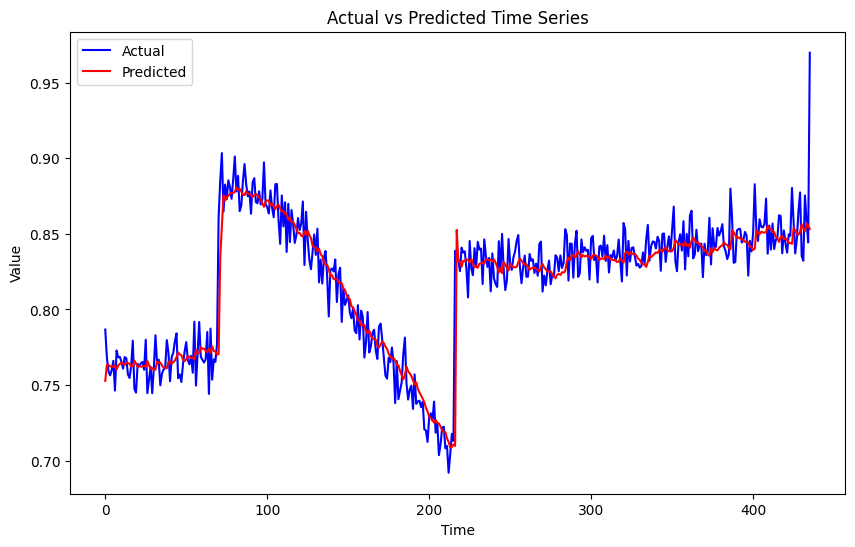

In [11]:
num_layers = best_model_info[0]
units = best_model_info[1]
activation = best_model_info[2]

model_name = f'best_model_GRU_{num_layers}_{units}_{activation}.keras'
loaded_model = load_model(model_name) 
loss, mae = loaded_model.evaluate(X_valid, y_valid)
print(f"Model Number of Layers: {num_layers}, activation : {activation}")
print("Validation Loss:", loss)
print("Validation Mean Absolute Error:", mae)


y_pred = loaded_model.predict(X_valid)
# Assuming timestamps are available for both y_pred and y_valid
timestamps = range(len(y_valid))
# Plot y_pred vs y_valid
plt.figure(figsize=(10, 6))
plt.plot(timestamps, y_valid, label='Actual', color='blue')
plt.plot(timestamps, y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()